##  Initialization

In [15]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import copy
from IPython.display import display
import json
from pathlib import Path
import sys



## 1. Consumer-level flexibility models

1A) We first consider that this consumer has a single (fully) flexible load and a rooftop
PV panel. They want to utilize their flexible load and rooftop PV production to
minimize their daily energy procurement cost. Their maximum hourly PV production
is perfectly known, but can be fully curtailed. Their load is fully flexible in each hour,
however, the consumer wants to satisfy a minimum (total) energy consumption at the
end of the day. They can sell/buy electricity to/from the distribution grid at an hourly
electricity price, but must pay an hourly grid tariff fee for all net imports and exports.
We analyze how these cost structures can impact their flexibility and profits.

iv) Implement this optimization problem in a programming language of your choice.
Provide a well-documented working code.

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[rosetta2] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 96 columns and 168 nonzeros
Model fingerprint: 0x63b9b656
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 3e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 57 rows and 42 columns
Presolve time: 0.00s
Presolved: 16 rows, 54 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4160000e+31   3.000000e+31   1.416000e+01      0s
       5    1.4377500e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.437750000e+01

Hourly schedule (hours 0..23):
 t | price | pv_avail | x (load) | u (pv used) | import I | export E
 0 |  1.10 |   0.000 |   0.000 

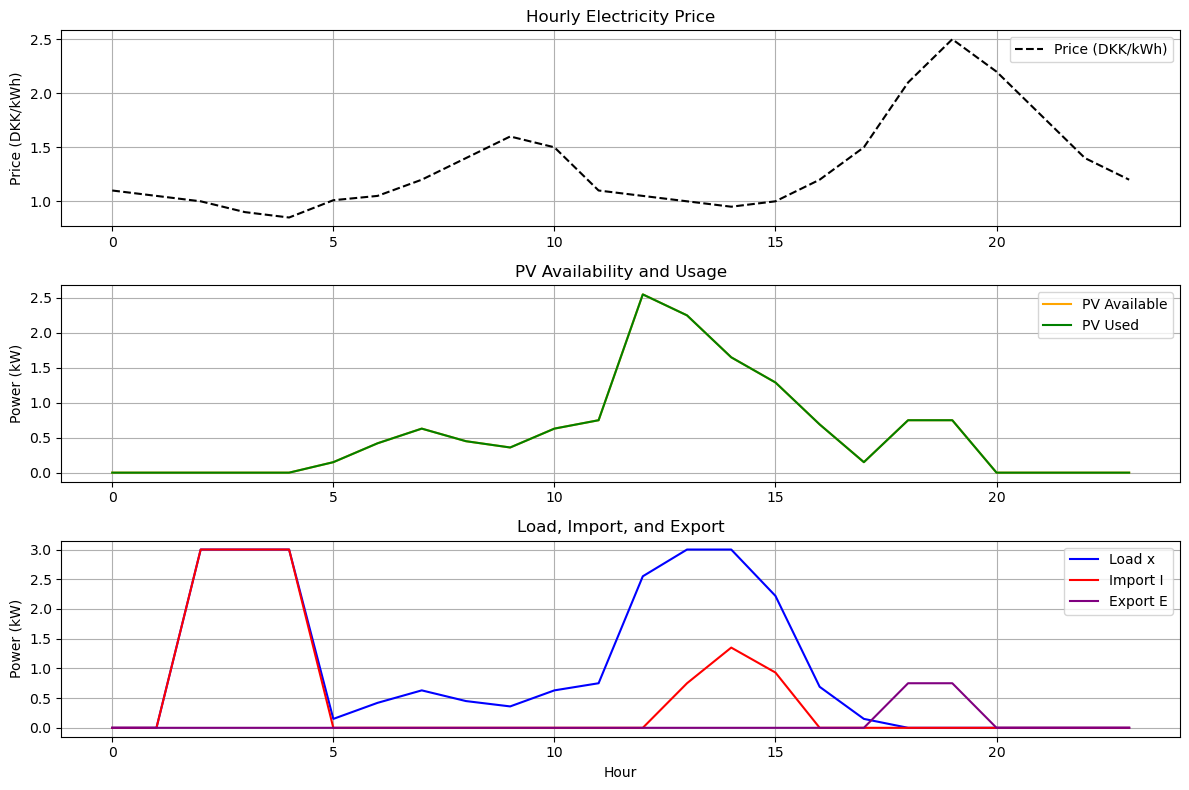

In [16]:
# Utility to load JSON

def load_json(path: Path):
    if path.exists():
        return json.loads(path.read_text())
    return None


# Paths
base_folder = Path("data/question_1a/")
appliance_path = base_folder / "appliance_params.json"
bus_path = base_folder / "bus_params.json"
consumer_path = base_folder / "consumer_params.json"
der_prod_path = base_folder / "DER_production.json"
usage_pref_path = base_folder / "usage_preference.json"

appliance_params = load_json(appliance_path)
bus_params = load_json(bus_path)
consumer_params = load_json(consumer_path)
DER_production = load_json(der_prod_path)
usage_pref = load_json(usage_pref_path)

# Single consumer / bus assumption for this assignment
consumer = consumer_params[0]
bus = bus_params[0]

# Extract specs
pv_spec = appliance_params["DER"][0]
pv_max_kW = float(pv_spec["max_power_kW"])

load_spec = appliance_params["load"][0]
load_max_kWh = float(load_spec["max_load_kWh_per_hour"])

prices = bus["energy_price_DKK_per_kWh"]
if len(prices) != 24:
    raise SystemExit("Expected 24 hourly prices; got %d" % len(prices))

import_tariff = float(bus["import_tariff_DKK/kWh"])
export_tariff = float(bus["export_tariff_DKK/kWh"])
max_import = float(bus["max_import_kW"])
max_export = float(bus["max_export_kW"])

der_profile = DER_production[0]["hourly_profile_ratio"]
if len(der_profile) != 24:
    raise SystemExit("Expected 24 hourly DER profile entries")

pv_avail = [pv_max_kW * float(r) for r in der_profile]

# daily minimum energy (8 equivalent hours * 3 kWh/h)
min_equivalent_hours = usage_pref[0]["load_preferences"][0]["min_total_energy_per_day_hour_equivalent"]
E_min = float(min_equivalent_hours) * load_max_kWh

T = list(range(24))

# Build model
m = gp.Model("consumer_flex_lp")
m.setParam('OutputFlag', 1)

# Variables
x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
u = m.addVars(T, lb=0.0, name="u")          # cap by constraints
I = m.addVars(T, lb=0.0, name="I")
E = m.addVars(T, lb=0.0, name="E")

# PV availability constraints
for t in T:
    m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")

# Energy balance
for t in T:
    m.addConstr(I[t] - E[t] + u[t] == x[t], name=f"balance_{t}")

# Load upper bound (already in var definition)
for t in T:
    m.addConstr(x[t] <= load_max_kWh, name=f"load_cap_{t}")

# Daily minimum
daily_min_con = m.addConstr(gp.quicksum(x[t] for t in T) >= E_min, name="daily_min_energy")

# Objective
obj = gp.quicksum((prices[t] + import_tariff) * I[t] - (prices[t] - export_tariff) * E[t] for t in T)
m.setObjective(obj, GRB.MINIMIZE)

# Optimize
m.optimize()

if m.status != GRB.OPTIMAL:
    print("Optimization status:", m.status)

# Results
x_sol = [x[t].X for t in T]
u_sol = [u[t].X for t in T]
I_sol = [I[t].X for t in T]
E_sol = [E[t].X for t in T]

total_import = sum(I_sol)
total_export = sum(E_sol)
total_load = sum(x_sol)
total_pv_used = sum(u_sol)
objective_value = m.ObjVal
shadow_daily_min = daily_min_con.Pi

print("\nHourly schedule (hours 0..23):")
print(" t | price | pv_avail | x (load) | u (pv used) | import I | export E")
for t in T:
    print(f"{t:2d} | {prices[t]:5.2f} | {pv_avail[t]:7.3f} | {x_sol[t]:7.3f} | {u_sol[t]:10.3f} | {I_sol[t]:8.3f} | {E_sol[t]:8.3f}")

print("\nTotals:")
print(f" Total load (sum x):        {total_load:.3f} kWh")
print(f" Total PV used (sum u):     {total_pv_used:.3f} kWh")
print(f" Total import (sum I):      {total_import:.3f} kWh")
print(f" Total export (sum E):      {total_export:.3f} kWh")
print(f" Objective (total cost):    {objective_value:.3f} DKK")
print(f" Shadow price (daily min):  {shadow_daily_min:.3f} DKK per kWh")

# Print binding constraints
print("\nBinding constraints (tight):")
for constr in m.getConstrs():
    if abs(constr.Slack) < 1e-6:
        print(f" {constr.ConstrName} is binding. Dual: {constr.Pi:.6f}")


# Plot schedule
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(T, prices, label="Price (DKK/kWh)", color='black', linestyle='--')
plt.ylabel("Price (DKK/kWh)")
plt.title("Hourly Electricity Price")
plt.grid()
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(T, pv_avail, label="PV Available", color='orange')
plt.plot(T, u_sol, label="PV Used", color='green')
plt.ylabel("Power (kW)")
plt.title("PV Availability and Usage")
plt.grid()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(T, x_sol, label="Load x", color='blue')
plt.plot(T, I_sol, label="Import I", color='red')
plt.plot(T, E_sol, label="Export E", color='purple')
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Load, Import, and Export")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


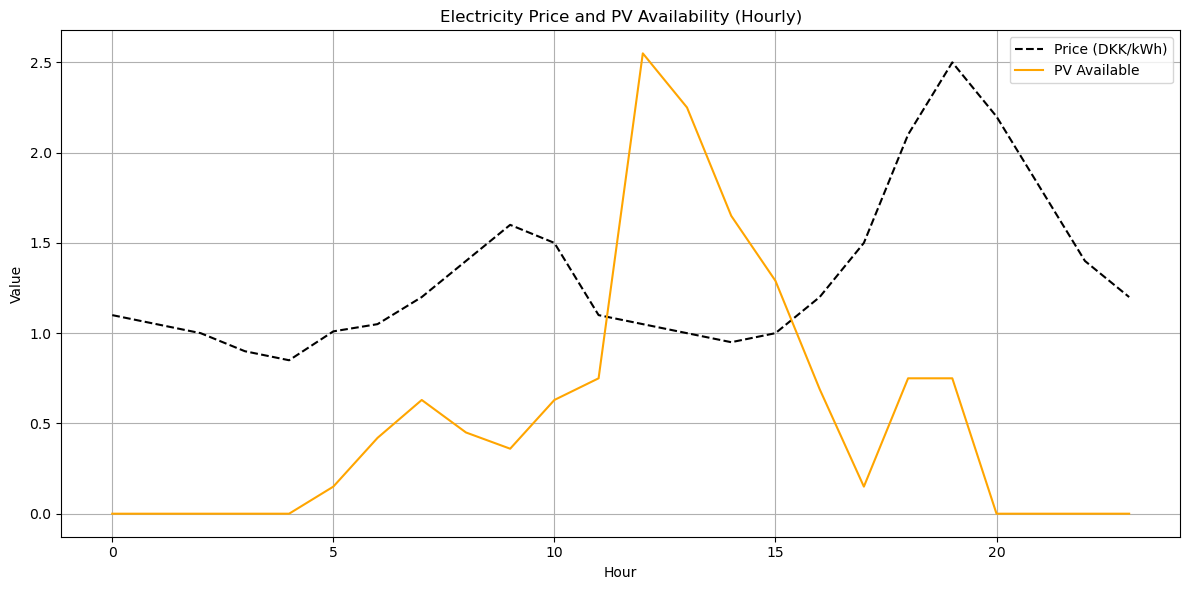

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(T, prices, label="Price (DKK/kWh)", color='black', linestyle='--')
plt.plot(T, pv_avail, label="PV Available", color='orange')
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("Electricity Price and PV Availability (Hourly)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


v) Construct relevant scenarios of system-level cost structures based on the data pro-
vided, solve this optimization problem over these scenarios, analyze its optimal
solutions (primal and dual) and answer the following question: How do cost struc-
tures impact the consumers flexibility and profits? Present your insights in a
compact manner using adequate visual aids. Do these solutions align with your
analysis from Question 1.(a).iii.?


=== Scenario Summary ===
        Scenario  Import tariff  Export tariff  Total Load (kWh)  PV Used (kWh)  Import (kWh)  Export (kWh)  Total Cost (DKK)  Shadow Price (DKK/kWh)
            Base            0.5            0.4              24.0          13.47         12.03          1.50           14.3775                    1.50
     High tariff            1.0            0.8              24.0          13.47         10.53          0.00           20.2425                    2.00
No export tariff            0.5            0.0              24.0          13.47         12.39          1.86           13.7415                    1.50
    Zero tariffs            0.0            0.0              24.0          13.47         18.66          8.13            6.6675                    1.05


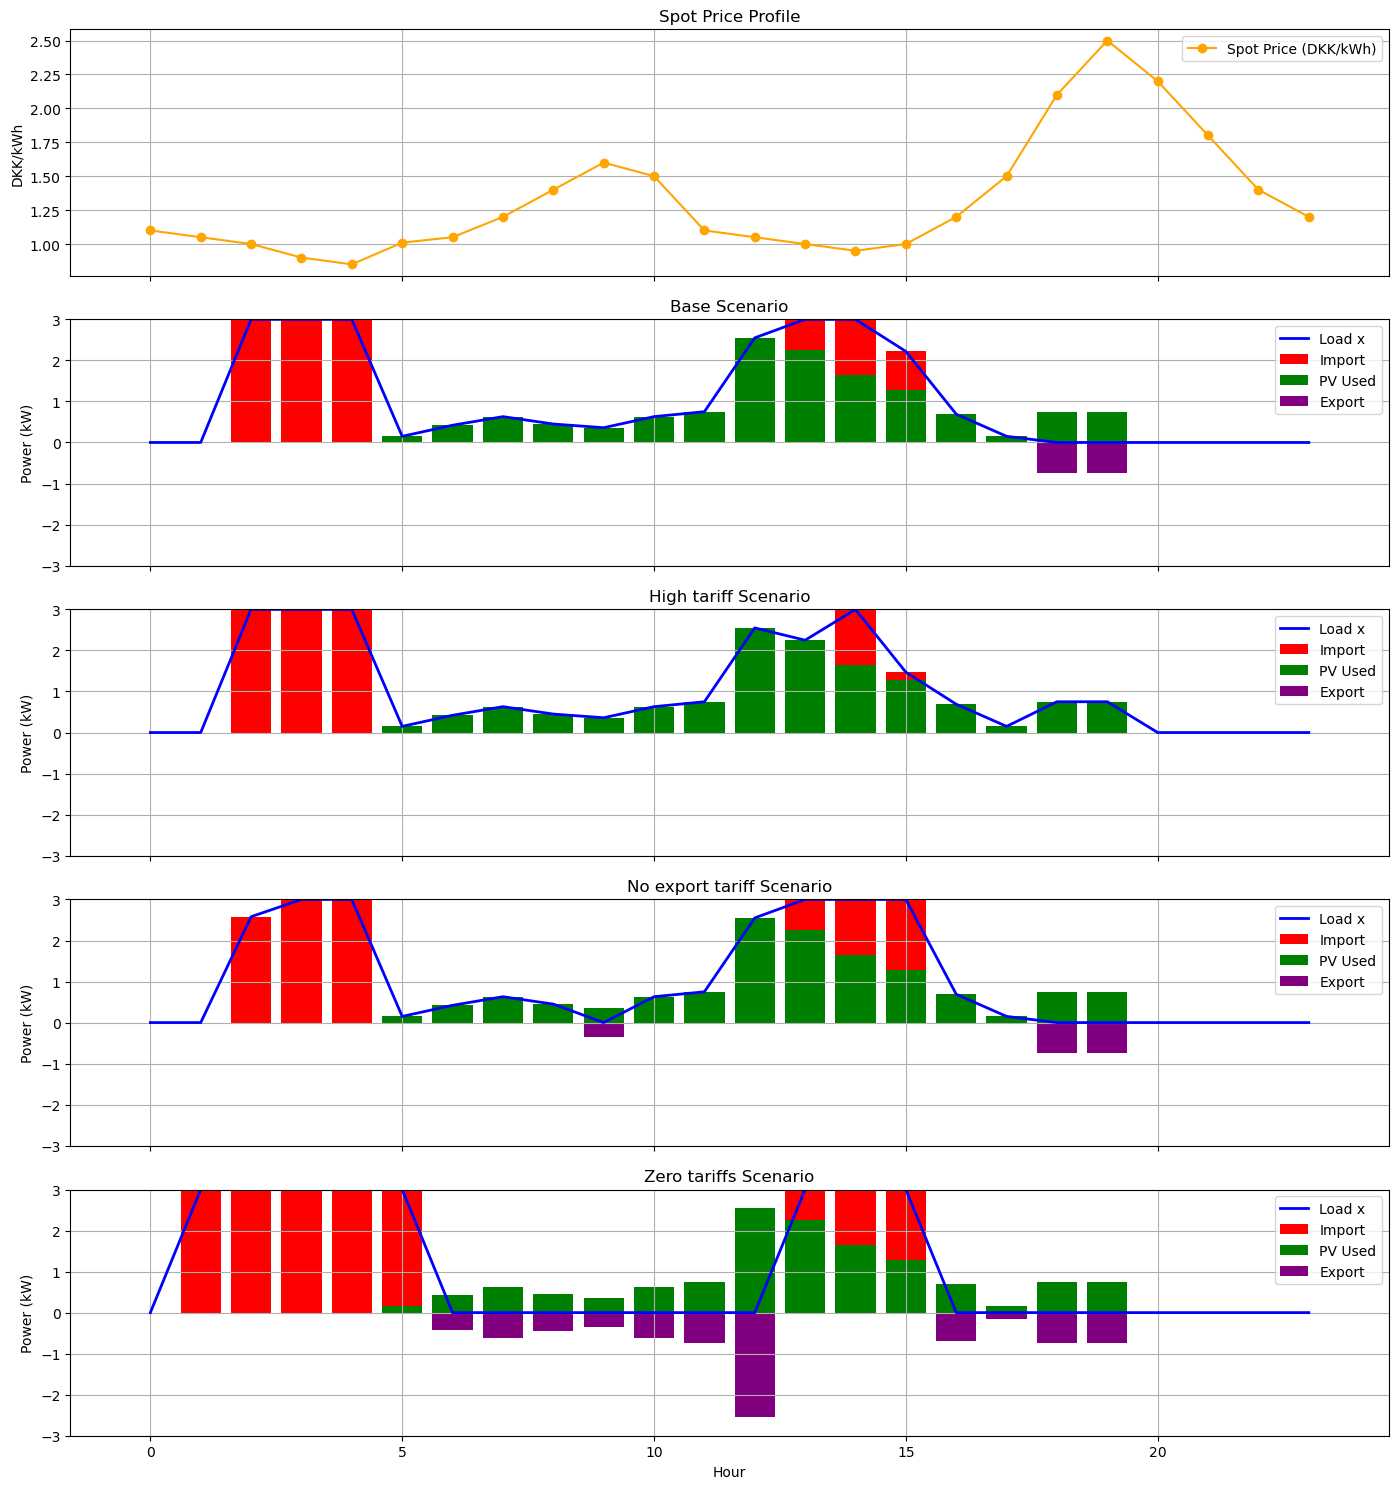

In [18]:
# Scenario analysis

scenarios = {
    "Base": {"import_tariff": 0.50, "export_tariff": 0.40},
    "High tariff": {"import_tariff": 1.00, "export_tariff": 0.80},
    "No export tariff": {"import_tariff": 0.50, "export_tariff": 0.00},
    "Zero tariffs": {"import_tariff": 0.00, "export_tariff": 0.00},
}

results = []

for name, sc in scenarios.items():
    # Build a new model for each scenario
    m = gp.Model(f"scenario_{name}")
    m.setParam('OutputFlag', 0)  # silence solver output

    # Variables
    x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
    u = m.addVars(T, lb=0.0, name="u")
    I = m.addVars(T, lb=0.0, name="I")
    E = m.addVars(T, lb=0.0, name="E")

    # Constraints
    for t in T:
        m.addConstr(u[t] <= pv_avail[t])
        m.addConstr(I[t] - E[t] + u[t] == x[t])
        m.addConstr(x[t] <= load_max_kWh)
    m.addConstr(gp.quicksum(x[t] for t in T) >= E_min, name="daily_min")

    # Objective
    obj = gp.quicksum((prices[t] + sc["import_tariff"]) * I[t]
                      - (prices[t] - sc["export_tariff"]) * E[t] for t in T)
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()

    if m.status == GRB.OPTIMAL:
        total_load = sum(x[t].X for t in T)
        total_import = sum(I[t].X for t in T)
        total_export = sum(E[t].X for t in T)
        total_pv_used = sum(u[t].X for t in T)
        total_cost = m.ObjVal
        dual_daily_min = m.getConstrByName("daily_min").Pi

        results.append({
            "Scenario": name,
            "Import tariff": sc["import_tariff"],
            "Export tariff": sc["export_tariff"],
            "Total Load (kWh)": total_load,
            "PV Used (kWh)": total_pv_used,
            "Import (kWh)": total_import,
            "Export (kWh)": total_export,
            "Total Cost (DKK)": total_cost,
            "Shadow Price (DKK/kWh)": dual_daily_min
        })

# Convert results to DataFrame
df = pd.DataFrame(results)
print("\n=== Scenario Summary ===")
print(df.to_string(index=False))

# Line plot for spot price
fig, axs = plt.subplots(len(scenarios) + 1, 1, figsize=(14, 3 * (len(scenarios) + 1)), sharex=True)

# First subplot: Spot price profile
axs[0].plot(T, prices, marker='o', color='orange', label='Spot Price (DKK/kWh)')
axs[0].set_title("Spot Price Profile")
axs[0].set_ylabel("DKK/kWh")
axs[0].grid(True)
axs[0].legend()

# Scenario subplots
for i, (name, sc) in enumerate(scenarios.items()):
    # Rebuild and solve model for scenario
    m = gp.Model(f"scenario_{name}")
    m.setParam('OutputFlag', 0)
    x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
    u = m.addVars(T, lb=0.0, name="u")
    I = m.addVars(T, lb=0.0, name="I")
    E = m.addVars(T, lb=0.0, name="E")
    for t in T:
        m.addConstr(u[t] <= pv_avail[t])
        m.addConstr(I[t] - E[t] + u[t] == x[t])
        m.addConstr(x[t] <= load_max_kWh)
    m.addConstr(gp.quicksum(x[t] for t in T) >= E_min, name="daily_min")
    obj = gp.quicksum((prices[t] + sc["import_tariff"]) * I[t]
                      - (prices[t] - sc["export_tariff"]) * E[t] for t in T)
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    if m.status == GRB.OPTIMAL:
        x_sol = np.array([x[t].X for t in T])
        I_sol = np.array([I[t].X for t in T])
        E_sol = np.array([E[t].X for t in T])
        u_sol = np.array([u[t].X for t in T])
        width = 0.8
        axs[i+1].bar(T, I_sol, width=width, label="Import", color='red', bottom=u_sol)
        axs[i+1].bar(T, u_sol, width=width, label="PV Used", color='green')
        axs[i+1].bar(T, -E_sol, width=width, label="Export", color='purple')
        axs[i+1].plot(T, x_sol, label="Load x", color='blue', linewidth=2)
        axs[i+1].set_title(f"{name} Scenario")
        axs[i+1].set_ylabel("Power (kW)")
        axs[i+1].grid()
        axs[i+1].set_ylim(-3, 3)
        axs[i+1].legend(loc='upper right')
axs[-1].set_xlabel("Hour")
plt.tight_layout()
plt.show()
